# CoM experts

In [7]:
import pandas as pd
import numpy as np



# Function to compute posture comfort
def compute_posture_comfort(df):
    comfort_scores = {}
    # Define the columns for key body parts
    body_parts = {
        "head": ["Marker_Skeleton:LBHD_Position_X", "Marker_Skeleton:LBHD_Position_Y", "Marker_Skeleton:LBHD_Position_Z"],
        "shoulder": ["Marker_Skeleton:LSHO_Position_X", "Marker_Skeleton:LSHO_Position_Y", "Marker_Skeleton:LSHO_Position_Z"],
        "elbow": ["Marker_Skeleton:LELB_Position_X", "Marker_Skeleton:LELB_Position_Y", "Marker_Skeleton:LELB_Position_Z"]
    }
    # Define the ideal ergonomic posture (example values, adjust as needed)
    ideal_posture = {
        "head": np.array([-500, 500, 1350]),  
        "shoulder": np.array([-500, 550,1120]),  # Shoulders slightly raised
        "elbow": np.array([-500, 550,900])  # Elbows slightly bent
    }
    for part, cols in body_parts.items():
        df_part = df[cols].values  # Extract X, Y, Z positions
        ref_position = ideal_posture[part]
        
        # Calculate Euclidean Distance from ideal posture
        displacement = np.linalg.norm(df_part - ref_position, axis=1)
        
        # Normalize values (higher values mean worse comfort)
        normalized_displacement = displacement / np.max(displacement) 
        
        # Store results
        comfort_scores[part] = normalized_displacement
    
    # Aggregate comfort scores across all body parts
    df_comfort = pd.DataFrame(comfort_scores)
    df_comfort["Overall_Posture_Comfort"] = df_comfort.mean(axis=1)
    
    return df_comfort

def clean_sudden_changes(dataframe, columns, threshold):
    """
    Removes sudden changes in specified columns of a DataFrame by replacing them
    with the preceding values.

    :param dataframe: pd.DataFrame - The input DataFrame
    :param columns: list - List of column names to clean
    :param threshold: float - The allowed threshold for change
    :return: pd.DataFrame - The modified DataFrame
    """
    # Copy the dataframe to avoid modifying the original
    cleaned_df = dataframe.copy()
    
    # Iterate over the specified columns
    for column in columns:
        # Iterate over the rows for the current column
        for i in range(1, len(cleaned_df)):
            current_value = cleaned_df.loc[i, column]
            previous_value = cleaned_df.loc[i - 1, column]
            
            # Check for sudden change
            if abs(current_value - previous_value) > threshold:
                cleaned_df.loc[i, column] = previous_value
    
    return cleaned_df

def calculate_com_divergence(df):
    """
    Calculate Center of Mass (CoM) and its divergence for given body parts.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing body part positions.
        body_parts (list): List of body part prefixes (e.g., ["LBHD", "LELB", "LSHO"]).
    
    Returns:
        pd.DataFrame: DataFrame with CoM positions and divergence.
    """
    body_parts = ["LBHD", "LELB", "LSHO"]  # Head, Elbow, Shoulder
    #body_parts = ["LELB"]  # Elbow
    # Extract position columns for each body part
    positions = {part: df[[f'Marker_Skeleton:{part}_Position_X',
                            f'Marker_Skeleton:{part}_Position_Y',
                            f'Marker_Skeleton:{part}_Position_Z']] 
                 for part in body_parts}
    
    # Compute Center of Mass (CoM) at each timestep
    com_df = pd.DataFrame()
    com_df['CoM_X'] = np.mean([positions[part].iloc[:, 0] for part in body_parts], axis=0)
    com_df['CoM_Y'] = np.mean([positions[part].iloc[:, 1] for part in body_parts], axis=0)
    com_df['CoM_Z'] = np.mean([positions[part].iloc[:, 2] for part in body_parts], axis=0)
    
    # Compute CoM divergence (from mean position)
    com_df['CoM_Divergence'] = np.sqrt(
        (com_df['CoM_X'] - com_df['CoM_X'].mean())**2 +
        (com_df['CoM_Y'] - com_df['CoM_Y'].mean())**2 +
        (com_df['CoM_Z'] - com_df['CoM_Z'].mean())**2
    )
    
    return com_df

# Example usage:
# Define body parts to include in CoM calculation
def process_csv(directory):
    filepath = directory
    data = pd.read_csv(filepath,on_bad_lines='skip',sep=',',header=[1,2,3,4,5])
    data.columns = data.columns.droplevel(2)
    data.columns = ['_'.join(map(str, col)).strip() for col in data.columns.values]
    data.rename(columns={'Type_Name_Unnamed: 1_level_3_Time (Seconds)':'Time'},inplace=True)
    data.rename(columns={'Unnamed: 0_level_0_Unnamed: 0_level_1_Unnamed: 0_level_3_Frame':'Frame'},inplace=True)
    columns_to_clean = ['Marker_Skeleton:LBHD_Position_X', 'Marker_Skeleton:LBHD_Position_Y','Marker_Skeleton:LBHD_Position_Z','Marker_Skeleton:LSHO_Position_X','Marker_Skeleton:LSHO_Position_Y','Marker_Skeleton:LSHO_Position_Z','Marker_Skeleton:LELB_Position_X','Marker_Skeleton:LELB_Position_Y','Marker_Skeleton:LELB_Position_Z']  # List of columns to clean
    threshold = 20  # Define a threshold for sudden changes
    df_filtered = clean_sudden_changes(data, columns_to_clean, threshold)
    df_com = calculate_com_divergence(df_filtered)
    final_df = pd.Series(dtype='float64')
    final_df['CoM_Divergence_Mean'] = df_com.mean()[3]
    final_df['CoM_Divergence_Max'] = df_com.max()[3]
    #final_df['CoM_Divergence_STD'] = df_com.std()[3]
    return final_df

import re
import os
def extract_trial_number(filename):
    """Extract the trial number from the filename."""
    match = re.search(r'TRIAL-(\d+)', filename)
    return int(match.group(1)) if match else None

from matplotlib import pyplot as plt

def process_csv(directory):
    filepath = directory
    data = pd.read_csv(filepath,on_bad_lines='skip',sep=',',header=[1,2,3,4,5])
    data.columns = data.columns.droplevel(2)
    data.columns = ['_'.join(map(str, col)).strip() for col in data.columns.values]
    data.rename(columns={'Type_Name_Unnamed: 1_level_3_Time (Seconds)':'Time'},inplace=True)
    data.rename(columns={'Unnamed: 0_level_0_Unnamed: 0_level_1_Unnamed: 0_level_3_Frame':'Frame'},inplace=True)
    columns_to_clean = ['Marker_Skeleton:LBHD_Position_X', 'Marker_Skeleton:LBHD_Position_Y','Marker_Skeleton:LBHD_Position_Z','Marker_Skeleton:LSHO_Position_X','Marker_Skeleton:LSHO_Position_Y','Marker_Skeleton:LSHO_Position_Z','Marker_Skeleton:LELB_Position_X','Marker_Skeleton:LELB_Position_Y','Marker_Skeleton:LELB_Position_Z']  # List of columns to clean
    threshold = 20  # Define a threshold for sudden changes
    df_filtered = clean_sudden_changes(data, columns_to_clean, threshold)
    df_com = calculate_com_divergence(df_filtered)
    
    
    return df_com,data

In [8]:
file_path = 'SBC/TRIAL-2/SOPHIA-RW-NO-VR-TRIAL-2-MOTIVE.csv'
df_com = process_csv(file_path)

df_com

(            CoM_X       CoM_Y        CoM_Z  CoM_Divergence
 0     -440.334147  696.806213  1126.275452       40.923087
 1     -440.308034  696.888204  1126.098145       40.839206
 2     -440.281535  696.969665  1125.916423       40.754011
 3     -440.253957  697.050293  1125.727620       40.666677
 4     -440.224162  697.130330  1125.530721       40.577662
 ...           ...         ...          ...             ...
 14457 -525.976278  699.770040  1099.747905       52.048009
 14458 -526.378123  699.726522  1099.857117       52.441793
 14459 -526.813406  699.679199  1099.980428       52.868464
 14460 -527.284007  699.631958  1100.115499       53.330156
 14461 -527.791575  699.589783  1100.261414       53.828651
 
 [14462 rows x 4 columns],
        Frame        Time  Bone_Skeleton:Skeleton_Rotation_X  \
 0          0    0.000000                          -1.537351   
 1          1    0.008333                          -1.546994   
 2          2    0.016667                          -1.55712

In [9]:
file_path = 'SBC/TRIAL-3/SOPHIA-RW-NO-VR-TRIAL-3-MOTIVE.csv'
df_com = process_csv(file_path)

df_com

(            CoM_X       CoM_Y        CoM_Z  CoM_Divergence
 0     -467.878123  712.876892  1138.861715       35.497268
 1     -467.978434  712.910339  1138.825623       35.386503
 2     -468.078969  712.927185  1138.783061       35.276940
 3     -468.191823  712.961975  1138.720886       35.143533
 4     -468.307526  712.995524  1138.668294       35.012225
 ...           ...         ...          ...             ...
 12840 -473.540527  725.135315  1128.177917       25.565036
 12841 -473.616445  724.891988  1128.204305       25.467146
 12842 -473.713857  724.667806  1128.218547       25.350158
 12843 -473.829020  724.416911  1128.250081       25.218530
 12844 -473.963775  724.173055  1128.257060       25.065841
 
 [12845 rows x 4 columns],
        Frame        Time  Bone_Skeleton:Skeleton_Rotation_X  \
 0          0    0.000000                          -3.203157   
 1          1    0.008333                          -3.194935   
 2          2    0.016667                          -3.18556

In [10]:
file_path = 'WBC/TRIAL-1/SOPHIE-RW-NO-VR-TRIAL-1-MOTIVE.csv'
df_com = process_csv(file_path)

df_com

(            CoM_X       CoM_Y        CoM_Z  CoM_Divergence
 0     -412.216848  660.369425  1159.643941       68.053733
 1     -412.105825  660.224853  1159.660563       67.918538
 2     -411.995555  660.081095  1159.677734       67.784439
 3     -411.888469  659.939677  1159.695577       67.654088
 4     -411.785217  659.802022  1159.711812       67.528411
 ...           ...         ...          ...             ...
 21121 -553.126343  578.406514  1151.378113      219.506785
 21122 -553.559824  578.580627  1151.321757      219.864584
 21123 -553.984874  578.765869  1151.257589      220.211654
 21124 -554.402120  578.957957  1151.186279      220.549944
 21125 -554.815440  579.153727  1151.110799      220.884007
 
 [21126 rows x 4 columns],
        Frame        Time  Bone_Skeleton:Skeleton_Rotation_X  \
 0          0    0.000000                          -1.231113   
 1          1    0.008333                          -1.204253   
 2          2    0.016667                          -1.18450

In [11]:
file_path = 'WBC/TRIAL-2/SOPHIE-RW-NO-VR-TRIAL-3-MOTIVE.csv'
df_com = process_csv(file_path)

df_com

(            CoM_X       CoM_Y        CoM_Z  CoM_Divergence
 0     -453.206390  638.609517  1130.224772      180.997115
 1     -452.071411  637.967590  1130.486003      179.709723
 2     -450.937154  637.318522  1130.746724      178.421827
 3     -449.804321  636.657369  1131.005107      177.133074
 4     -448.671417  635.978333  1131.259420      175.840810
 ...           ...         ...          ...             ...
 18331 -507.099599  607.633657  1150.419332      227.670854
 18332 -508.296305  607.233866  1150.574402      228.833482
 18333 -509.485006  606.827067  1150.714417      229.988843
 18334 -510.667145  606.413289  1150.844848      231.138351
 18335 -511.842946  605.994151  1150.968526      232.282338
 
 [18336 rows x 4 columns],
        Frame        Time  Bone_Skeleton:Skeleton_Rotation_X  \
 0          0    0.000000                          -1.522188   
 1          1    0.008333                           1.685845   
 2          2    0.016667                           3.43273

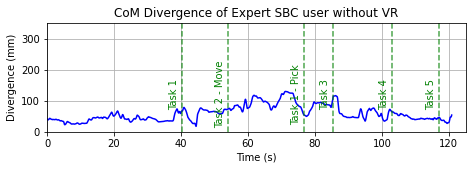

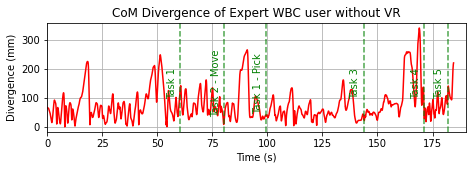

In [16]:
#################### READING COMPLETION TIMES FROM EXPERTS ##################

csv_data_sbc = pd.read_csv('SBC/TRIAL-2/subtask_topic.csv')
task_times_sbc = csv_data_sbc['data'].tolist()  # Assuming column 'data' exists in the CSV

# FOR WBC
csv_data_wbc = pd.read_csv('WBC/TRIAL-1/subtask_topic.csv')
task_times_wbc = csv_data_wbc['data'].tolist()  # Assuming column 'data' exists in the CSV

file_path_sbc = 'SBC/TRIAL-2/SOPHIA-RW-NO-VR-TRIAL-2-MOTIVE.csv'
df_com_sbc,data_sbc = process_csv(file_path_sbc)

file_path_wbc = 'WBC/TRIAL-1/SOPHIE-RW-NO-VR-TRIAL-1-MOTIVE.csv'
df_com_wbc,data_wbc = process_csv(file_path_wbc)

tasks = ["Task 1","Task 2 - Move","Task 1 - Pick","Task 3","Task 4", "Task 5"]

plt.figure(1,figsize=(7.5, 2))
plt.plot(data_sbc['Time'], df_com_sbc['CoM_Divergence'], linestyle='-', color='b', label='CoM Divergence')
plt.xlabel('Time (s)')
plt.ylabel('Divergence (mm)')
plt.title(f'CoM Divergence of Expert SBC user without VR')
ax = plt.gca()
ax.set_xlim([0, 125])
ax.set_ylim([0, 350])
#plt.legend()
plt.grid(True)



i=0
for task_time in task_times_sbc:
    plt.axvline(x=task_time, color="green", linestyle="--", alpha=0.7)
    # Position annotation in the middle of the vertical line and shift it to the left
    middle_y = 120#(max(category_mapping.values()) + min(category_mapping.values())) / 2
    plt.text(task_time - 0.008 * (data_sbc["Time"].max() - data_sbc["Time"].min()),  # Shift left by 2% of the time range
             middle_y,  # Position the annotation
             tasks[i], color="green", fontsize=10, rotation=90, verticalalignment="center", horizontalalignment="right")
    i += 1

output_path = f"expert_sbc_com.pdf"  # Specify your desired file path
plt.savefig(output_path, format='pdf')

plt.figure(2,figsize=(7.5, 2))
plt.plot(data_wbc['Time'], df_com_wbc['CoM_Divergence'], linestyle='-', color='r', label='CoM Divergence')
plt.xlabel('Time (s)')
plt.ylabel('Divergence (mm)')
plt.title(f'CoM Divergence of Expert WBC user without VR')
ax = plt.gca()
ax.set_xlim([0, 190])
#plt.legend()
plt.grid(True)


i = 0
for task_time in task_times_wbc:
    plt.axvline(x=task_time, color="green", linestyle="--", alpha=0.7)
    # Position annotation in the middle of the vertical line and shift it to the left
    middle_y = 150#(max(category_mapping.values()) + min(category_mapping.values())) / 2
    plt.text(task_time - 0.008 * (data_wbc["Time"].max() - data_wbc["Time"].min()),  # Shift left by 2% of the time range
             middle_y,  # Position the annotation
             tasks[i], color="green", fontsize=10, rotation=90, verticalalignment="center", horizontalalignment="right")
    i += 1

output_path = f"expert_wbc_com.pdf"  # Specify your desired file path
plt.savefig(output_path, format='pdf')

plt.show()
